In [2]:
import time

import numpy as np
import torch
import torch.utils
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from mnist import TinyCNN, train_one_epoch

from concrete.ml.torch.compile import compile_torch_model

%matplotlib inline

import matplotlib.pyplot as plt

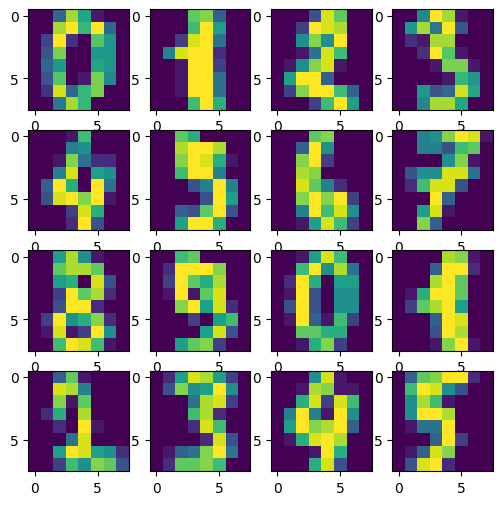

In [4]:
X, y = load_digits(return_X_y=True)

X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())

plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

Training: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]


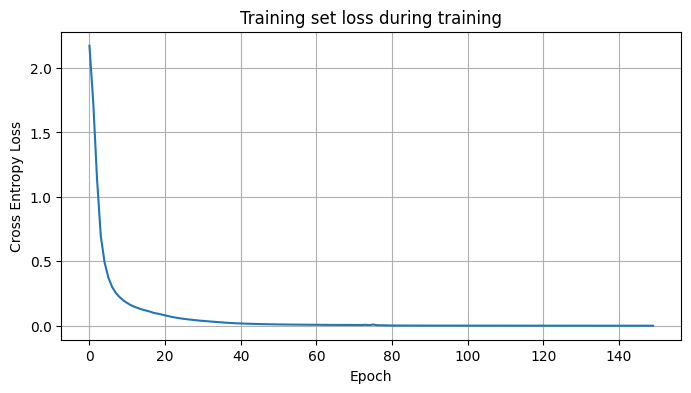

In [8]:
N_EPOCHS = 150

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

net = TinyCNN(10)
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_dataloader))

fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

In [18]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy for fp32 weights and activations: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )

test_torch(net, test_dataloader)

Test accuracy for fp32 weights and activations: 98.22%


## MNIST with FHE

In [19]:
def test_with_enc(quantized_module, test_loader, use_sim):
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        all_targets[idx:endidx] = target
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        idx += target.shape[0]
    
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

In [21]:
n_bits = 6

q_module = compile_torch_model(net, x_train, rounding_threshold_bits=6, p_error=0.1)

In [22]:
q_module.fhe_circuit.keygen()

In [26]:
mini_test_dataset = TensorDataset(torch.Tensor(x_test[:10, :]), torch.Tensor(y_test[:10]))
mini_test_dataloader = DataLoader(mini_test_dataset)

accuracy_test = test_with_enc(
    q_module,
    mini_test_dataloader,
    use_sim=False
)

print(f"FHE-MNIST with {accuracy_test * 100:.2f}% accuracy")

100%|██████████| 10/10 [01:38<00:00,  9.80s/it]

FHE-MNIST with 100.00% accuracy


In [30]:
from pathlib import Path

model = net.to("cpu")

dir = Path(".")
torch.save(
    model.state_dict(), f"{dir}/mnist_state_dict.pt"
)

In [10]:
a_model = TinyCNN(10)
a_model.load_state_dict(torch.load("mnist_state_dict.pt"))
a_model.eval()
id = 2

X, y = load_digits(return_X_y=True)
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)
input_tensor = torch.Tensor(X)

a_output = a_model(input_tensor).argmax(1).detach().numpy()
print(a_output.tolist())
print(y.tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 

### Step-by-step

In [3]:
X, y = load_digits(return_X_y=True)
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

model = TinyCNN(10)
model.load_state_dict(torch.load("mnist_state_dict.pt"))

q_model = compile_torch_model(model, x_train, rounding_threshold_bits=6, p_error=0.1)

In [4]:
X = X[2].reshape(1, 1, 8, 8)

q_model.fhe_circuit.keygen()
X_q = q_model.quantize_input(X)
X_q_enc = q_model.fhe_circuit.encrypt(X_q)
output_q_enc = q_model.fhe_circuit.run(X_q_enc)
output_q = q_model.fhe_circuit.decrypt(output_q_enc)
output = q_model.dequantize_output(output_q)
output_proba = q_model.post_processing(output)
output_class = output_proba.argmax(1)

In [25]:
from concrete.ml.common.serialization.dumpers import dumps

In [34]:
import base64
base64.b64encode(X_q_enc.serialize())

b'AQAAAF8AAgADAAAAAAAAAAAAAAAAAAMACAAAAAAAAQAMAQgAAQABACABCAABAAEAAQAAAA4AAAABAAAAAhCAAG70UEKT9/HcUYMXt/h+xt6sPOReOHOebtQWtE3WnXntK3HCoRZsCRJMoqXI54Kk1TYbq6W+g4XCsPQ5nxy4R8RszqnL1y+BRTNl0juvX8nP+RUGwGk3SrFZcGDpXUx+0st1fZyDJIBnft6O6NxVz4bahJx1DRmOHT7aZxLxsflaE9okKAHLYv3C6SqZvTHg7Df+9LxTLemlAreZNV49/uyB4yWoBca7o0IMoXG4F3GOtJ+pe6n1tkeMMPML6nLx+7iQ5hGVLsr/71FD/p0IBSBVTKvHvwKMm6u1GnlKoa1K/CgAV8Wzp7ieaKtbmiifX6k1V97Z1jfXPfYyl0WytVyeDiyIhI0T1+mMhHcaXxUU8Z9i/mUMt7sjDgCSP+BGPfUSAb+a/992ajXmF2IR83e9LBi9NyALRsCUIpoje0WMeYe2Ek2mA4WcSD8UxFcdEyNxiGI7GsP514if/ETTxbjC0OAQYaSGNirvaRWXpaVQ0XsGmcYhja2D3uWcKgQ7LdN24KkRATn9eLoF1uw2FmiRyo8YjO1KgMbgcxZmqETFrhCIRR8hrVXDffJLLhwznNpQc1JSoGkPJioII0MypZVM6bV2UrAcUBvzJpR1nLscDiAmcbu5UGoB2+jaCngEkVpgZ+BIfgbNvPUCI1mQ+ynawvrqa+zA74Vd0oj/VGy8FzYL9V3MYIX1qELoykROn/G56u96Y+9gnx3apEiKfG6loVMY4e8cxc+uC3TP3hnov8WOeXEO8fVnVXZvZNix/cneSvTBXRRfMw3AmRKoxlleQE+qklTvXVVJMGpJUhgXNdTm6H+rGf3EsOP074g7/NZR8PZ9TtgGcPU1KGiX+abXAm+3rtfodgCeNdsPII0KuObf4puOXvRw3QbTXFcXGIp4ASwPHoGkO1Fbff

## Reference

- https://docs.zama.ai/concrete-ml/deep-learning/examples#id-2.-custom-convolutional-nn-on-the-digits-data-set
- https://github.com/zama-ai/concrete-ml/blob/release/1.4.x/docs/advanced_examples/ConvolutionalNeuralNetwork.ipynb
- https://docs.zama.ai/concrete-ml/deep-learning/fhe_friendly_models
